In [1]:
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
import re
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import ttest_rel
from scipy.stats import ttest_ind

In [2]:
fpath = 'izev-wsts-_september_2022_stats_for_web_publishing-en.ods'

sheet_index = 1
dfinc = read_ods(fpath, sheet_index)

fpath2 = '20100024.csv' 
dfreg = pd.read_csv(fpath2)

fpath3 = 'provinces.csv'
dfprov = pd.read_csv(fpath3, index_col = 'Name')


In [3]:
test = dfreg.copy()
test['REF_DATE'].replace('\d\d\d\d-', '', regex = True, inplace = True)
test['REF_DATE']=test['REF_DATE'].astype('int32')

test = test.loc[test['GEO']=='Canada'].groupby(['REF_DATE']).sum().reset_index()

regfraction = (test['VALUE'].sum())/(test.loc[1,'VALUE'] + test.loc[0,'VALUE'])

In [4]:
test2 = dfinc.copy()
test2.loc[test2['Calendar Year'].isin([2020,2021])]
test2['Month and Year '].replace(' .*', '', regex = True, inplace = True)

monthmap = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}

test2['Month and Year '] = test2['Month and Year '].map(monthmap)

test2 = test2.groupby(['Month and Year ']).sum().reset_index()

incfraction2019 = test2['Eligible Incentive Amount'].sum()/test2.loc[5:12,'Eligible Incentive Amount'].sum()
incfraction2022 = test2['Eligible Incentive Amount'].sum()/test2.loc[1:9,'Eligible Incentive Amount'].sum()


In [5]:
provmap = {'British Columbia':'British Columbia and the Territories'
           , 'Northwest Territories':'British Columbia and the Territories'
           , 'Yukon':'British Columbia and the Territories'
           , 'Quebec':'Quebec'
           , 'Ontario':'Ontario'
           , 'Manitoba':'Manitoba'
           , 'New Brunswick':'New Brunswick'
           , 'Saskatchewan':'Saskatchewan'
           , 'Nova Scotia':'Nova Scotia'
           , 'Alberta':'Alberta'
           , 'Prince Edward Island':'Prince Edward Island'
           , 'Newfoundland and Labrador':'Newfoundland and Labrador'}

popmap = dfprov['Population Total'].to_dict()

provlist = ['Prince Edward Island', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'British Columbia and the Territories']
yearlist = [2019,2020,2021,2022]
          

dfinc['Recipient Province / Territory ']=dfinc['Recipient Province / Territory '].map(provmap)

In [6]:
dfinc['Calendar Year']=dfinc['Calendar Year'].astype('int32')
dfreg['REF_DATE'].replace('-\d\d', '', regex = True, inplace = True)
dfreg['REF_DATE']=dfreg['REF_DATE'].astype('int32')

In [7]:
incentive = dfinc.iloc[:,[3,7,10,11]]
incentive.columns=['Year','Type','Total Incentive','Province']
incentive = incentive.loc[incentive['Province'].isin(provlist)]

In [8]:
register = dfreg.iloc[:,[0,1,3,12]]
register.columns=['Year','Province','Type','Registrations']
register = register.loc[register['Province'].isin(provlist)]

In [9]:
register['Type'] = register['Type'].map({'All fuel types':'Not EV', 'Gasoline':'Not EV', 'Diesel':'Not EV', 'Battery electric':'EV',
       'Hybrid electric':'EV', 'Plug-in hybrid electric':'EV', 'Other fuel types':'Not EV'})

In [10]:
finalreg = register.groupby(['Province','Year','Type'])['Registrations'].apply('sum').reset_index()
finalinc = incentive.groupby(['Province','Year']).sum().reset_index()

In [11]:
finalreg['Population'] = finalreg['Province'].map(popmap)
finalreg['Reg/Pop'] = finalreg['Registrations']/finalreg['Population']

In [12]:
finaldf = pd.merge(finalreg, finalinc, on=['Province', 'Year'], how = 'outer').fillna(0)

def incMap(n):
    if n == 0:
        return 'No'
    else:
        return 'Yes'          

finaldf['Is Incentive'] = finaldf['Total Incentive'].map(incMap)
finaldf['Inc/Pop'] = finaldf['Total Incentive']/finaldf['Population']

In [13]:
finaldf.loc[finaldf['Year'] == 2022,'Registrations'] *= regfraction
finaldf.loc[finaldf['Year'] == 2022,'Reg/Pop'] *= regfraction
# finaldf.loc[finaldf['Year'] == 2022,'Inc/Pop'] *= incfraction2022
# finaldf.loc[finaldf['Year'] == 2019,'Inc/Pop'] *= incfraction2019
finaldf.loc[finaldf['Year'] == 2022,'Inc/Pop'] *= 3/2
finaldf.loc[finaldf['Year'] == 2019,'Inc/Pop'] *= 4/3

In [14]:
er = finaldf.loc[finaldf['Type']=='EV'].reset_index()['Registrations']/finaldf.loc[finaldf['Type']=='Not EV'].reset_index()['Registrations']

finaldf['EV/Reg'] = np.repeat(er.values,2)

# Electric Vehicle Incentives Analysis
---
## Objectives and Data Preparation

We wanted to discover how effective the Incentives for Zero-Emission Vehicles (iZEV) program has been at encouraging Canadian consumers to purchase electric vehicles as apposed to traditional ones. The data that we were interested in analyzing were data related to the number of vehicles registered in Canada in the years before and after the IZEV program was intruduced. We also wanted to look at how popular the iZEC program is, how much it has been used and how the incentives offered through the program have been related to the change in vehicle registrations.

Data about new vehicle registrations in Canada was retrieved from Statistics Canada. The data included the number of vehicle registrations in each province, for the years 2017-2022, sorted by vehicle type. Data was not available for Alberta, Newfoundland or New Brunswick. The data was downloaded as a .csv file from the Statistics Canada website. Data related to the economic incentives granted by the iZEV program was also retrieved from the government of Canada's Open Government Portal. The data summarizes all instances of incentives recieved by consumers, sorted by province and vehicle type. The data was also downloaded as a .csv file from the Government of Canada Open Government website.

In [15]:
# test2 = dfinc.copy()
# test2.loc[test2['Calendar Year'].isin([2020,2021])]
# test2['Month and Year '].replace(' .*', '', regex = True, inplace = True)

# monthmap = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}

# test2['Month and Year '] = test2['Month and Year '].map(monthmap)

# anov = ols('VALUE ~ REF_DATE', data=test).fit()
# anova_table = sm.stats.anova_lm(anov, typ=2)
# anova_table

---
##  Initial Analysis

The first step in the analysis was to examine the trends that took place over the 2017-2022 period that was being examined. By looking first at the change in the fraction of vehicle regitrations that are EVs, and the EV and non-EV registrations per capita, several trends become clear. Not only has the fraction of vehicles that are EVS consistently been increasing, but the raw number of EV registrations per capita has been increasing, while the non-EV registrations have been decreasing. It can be seen there is a clear trend towards more  EV registrations and a higher fraction of EV vehicles. 

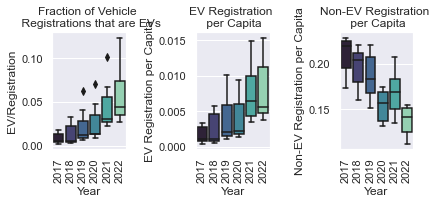

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.set(rc={'figure.figsize':(6,4)})

plot = sns.boxplot(data=finaldf.loc[finaldf['Type']=='EV'], x="Year", y="EV/Reg", palette = sns.color_palette("mako"), ax = ax1)
plot.set(title='Fraction of Vehicle \n Registrations that are EVs')
plot.set(xlabel='Year', ylabel='EV/Registration')
plt.setp(plot.get_xticklabels(), rotation=90)

plot = sns.boxplot(data=finaldf.loc[finaldf['Type']=='EV'], x="Year", y="Reg/Pop", palette = sns.color_palette("mako"), ax = ax2)
plot.set(title='EV Registration \n per Capita')
plot.set(xlabel='Year', ylabel='EV Registration per Capita')
plt.setp(plot.get_xticklabels(), rotation=90)

plot = sns.boxplot(data=finaldf.loc[finaldf['Type']=='Not EV'], x="Year", y="Reg/Pop", palette = sns.color_palette("mako"), ax = ax3)
plot.set(title='Non-EV Registration \n per Capita')
plot.set(xlabel='Year', ylabel='Non-EV Registration per Capita')
plt.setp(plot.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

---
## Hypothesis Testing

If we compare the distributions of EV and non-EV vehicles per capita registration, depending on whether they were registered during a period of time that the iZEV incentives were in place, it is possible to see that EV registrations are higher after the incentives came into place, and non-EV registrations were lower. This all combines to give us some motivation to determine if the incentives were specifically influenced by the iZEV incentives. The below t-tests show that there is a significant difference in the mean of the fraction of EV registrations before and after the incentives with an $\alpha$ = 0.05. There is also significant result showing an increase in the EV registrations per capita, and a decrease in the non-EV registrations per capita over the same time periods. 

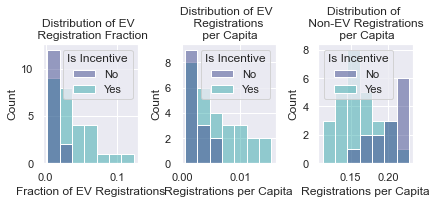

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.set(rc={'figure.figsize':(4,3)})


copy = finaldf.copy()
# copy['EV/Reg']=np.sqrt(copy['EV/Reg'])

# fig, (ax1, ax2) = plt.subplots(1, 2)

plot = sns.histplot(data = copy.loc[copy['Type']=='EV'], x = 'EV/Reg', hue = 'Is Incentive', palette = sns.color_palette("mako", 2), ax = ax1)
plot.set(title='Distribution of EV \n Registration Fraction')
plot.set(xlabel='Fraction of EV Registrations', ylabel='Count')


# plot = sns.histplot(data = copy.loc[copy['Type']=='Not EV'], x = 'EV/Reg', hue = 'Is Incentive', palette = sns.color_palette("mako", 2), ax = ax2)
# plot.set(title='Distribution of Non-EV Registrations Fraction')
# plot.set(xlabel='Fraction of EV Registrations', ylabel='Count')

plot = sns.histplot(data = finaldf.loc[finaldf['Type']=='EV'], x = 'Reg/Pop', hue = 'Is Incentive', palette = sns.color_palette("mako", 2), ax = ax2)
plot.set(title='Distribution of EV \n Registrations \n per Capita')
plot.set(xlabel='Registrations per Capita', ylabel='Count')


plot = sns.histplot(data = finaldf.loc[finaldf['Type']=='Not EV'], x = 'Reg/Pop', hue = 'Is Incentive', palette = sns.color_palette("mako", 2), ax = ax3)
plot.set(title='Distribution of \n Non-EV Registrations \n per Capita')
plot.set(xlabel='Registrations per Capita', ylabel='Count')


plt.tight_layout() 
plt.show()


In [43]:
a1 = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Is Incentive'] == 'Yes')]['EV/Reg']
b1 = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Is Incentive'] == 'No')]['EV/Reg']


a = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Is Incentive'] == 'Yes')]['Reg/Pop']
b = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Is Incentive'] == 'No')]['Reg/Pop']

c = finaldf.loc[(finaldf['Type'] == 'Not EV') & (finaldf['Is Incentive'] == 'Yes')]['Reg/Pop']
d = finaldf.loc[(finaldf['Type'] == 'Not EV') & (finaldf['Is Incentive'] == 'No')]['Reg/Pop']



df = {'T-test Statistic': [ttest_ind(a1,b1)[0], ttest_ind(a,b)[0], ttest_ind(c,d)[0]], 'p Value': [ttest_ind(a1,b1)[1], ttest_ind(a,b)[1], ttest_ind(c,d)[1]]}
df = pd.DataFrame(data=df, index = ['EV Fraction','EV Registrations','Non-EV Registrations'])

df

,T-test Statistic,p Value
EV Fraction,3.343128,0.001807
EV Registrations,3.147916,0.003104
Non-EV Registrations,-4.796601,0.000023


However, looking at year-to-year comparisons instead of simply comparing the before and after periods shows that there is no significant difference in the jump from 2018 to 2019 - or in an individual year - which casts doubt on the idea that the iZEV incentives are specifically responsible for the difference noted above, instead of simply the trend of increased popularity of EV that can be seen in the yearly registration data.

In [55]:
t = []
for y in [2018]:
    a = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Year'] == y)]['EV/Reg']
    b = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Year'] == y+1)]['EV/Reg']
    t.append(ttest_ind(a,b)[1])
    
t2 = []
for y in [2018]:
    a = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Year'] == y)]['Reg/Pop']
    b = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Year'] == y+1)]['Reg/Pop']
    t2.append(ttest_ind(a,b)[1])
    

d = {'Years': ['2018-2019'], 'p Value of T-test for EV fraction': t, 'p Value of T-test for Registrations per Capita': t2}
df = pd.DataFrame(data=d)
df

,Years,p Value of T-test for EV fraction,p Value of T-test for Registrations per Capita
0,2018-2019,0.368296,0.407797


---
## Conclusions

While it is certainly the case that electric vehicles have increased in popularity over the years from 2017-2022, and there is a correlation between the increase and the iZEV incentive program, there does not appear to be strong evidence that the incentive program itself had a significant effect. If it had had an effect, we would probably expect to see a particularly large increase in EV registrations in the year or two after they came into effect, and while there is an increase, there does not seem to be anything special about the jump from 2018-2019. 